<a href="https://colab.research.google.com/github/Michwynn/Capstone-Team-Air-/blob/Machine-Learning/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # supress warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import xgboost
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Capstone

pd.set_option('display.max_columns', None)

# random seed 
RANDOM_SEED = 44

Mounted at /content/drive
/content/drive/My Drive/Capstone


**import files**

In [2]:
train_df = pd.read_csv("assets/cleaned_assets/train_df.csv", index_col = 0)
val_df = pd.read_csv("assets/cleaned_assets/val_df.csv", index_col = 0)
test_df = pd.read_csv("assets/cleaned_assets/test_df.csv", index_col = 0)

**Baseline model to prevent dummy variable trap**

In [3]:
baseline_vars = ['City of London', 
                 'host_has_profile_pic_f', 
                 'host_identity_verified_f', 
                 'Entire home', 
                 'Entire home/apt (room type)']

# drop in all splitted dfs
train_df = train_df.drop(baseline_vars, axis=1)
val_df = val_df.drop(baseline_vars, axis=1)
test_df = test_df.drop(baseline_vars, axis=1)

# check whether they have been dropped
train_df.head(3)

,total_crimes,Population per square kilometre,Property price,accommodates,minimum_nights,maximum_nights,number_of_reviews,amenities_count,closest_station_dist,within_1k_station,closest_POI_dist,within_5k_POI,dist_from_center,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith and Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington and Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,host_has_profile_pic_t,host_identity_verified_t,Barn,Boat,Camper/RV,Campsite,Casa particular,Earthen home,Entire bungalow,Entire cabin,Entire chalet,Entire condo,Entire cottage,Entire guest suite,Entire guesthouse,Entire home/apt,Entire loft,Entire place,Entire rental unit,Entire serviced apartment,Entire townhouse,Entire vacation home,Entire villa,Floor,Houseboat,Hut,Island,Minsu,Private room,Private room in bed and breakfast,Private room in boat,Private room in bungalow,Private room in cabin,Private room in camper/rv,Private room in casa particular,Private room in chalet,Private room in condo,Private room in cottage,Private room in earthen home,Private room in farm stay,Private room in guest suite,Private room in guesthouse,Private room in home,Private room in hostel,Private room in houseboat,Private room in hut,Private room in island,Private room in lighthouse,Private room in loft,Private room in minsu,Private room in nature lodge,Private room in religious building,Private room in rental unit,Private room in serviced apartment,Private room in shepherd's hut,Private room in tiny home,Private room in tipi,Private room in townhouse,Private room in treehouse,Private room in vacation home,Private room in villa,Private room in yurt,Religious building,Room in aparthotel,Room in bed and breakfast,Room in boutique hotel,Room in hostel,Room in hotel,Room in rental unit,Room in serviced apartment,Shared room,Shared room in bed and breakfast,Shared room in boutique hotel,Shared room in bungalow,Shared room in condo,Shared room in guest suite,Shared room in guesthouse,Shared room in home,Shared room in hostel,Shared room in hotel,Shared room in loft,Shared room in rental unit,Shared room in serviced apartment,Shared room in townhouse,Shared room in vacation home,Shared room in villa,Shepherd’s hut,Tent,Tiny home,Tower,Yurt,Hotel room (room type),Private room (room type),Shared room (room type),price,log_price
57438,0.626898,1.000000,0.075281,0.333333,0.079181,0.112411,0.006832,0.179245,0.037670,0.333333,0.073765,0.15625,0.290881,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,203.0,5.313206
13473,0.555970,0.139861,0.081689,0.200000,0.003559,0.112411,0.003416,0.367925,0.341942,0.000000,0.734948,0.00000,0.671683,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,85.0,4.442651
58798,0.626898,1.000000,0.075281,0.066667,0.000890,0.112411,0.000000,0.386792,0.011696,0.166667,0.070028,0.53125,0.172582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,186.0,5.225747


**Split into x_train & y_train, X_val & y_val and X_test & y_test**

In [6]:
outcome_vars = ['price', 'log_price']

X_train = train_df[train_df.columns.difference(outcome_vars)]
y_train = list(train_df.log_price)

X_val = val_df[val_df.columns.difference(outcome_vars)]
y_val = list(val_df.log_price)

X_test = test_df[test_df.columns.difference(outcome_vars)]
y_test = list(test_df.log_price)

**Using Statsmodel for multiple regression**

In [14]:
model = sm.OLS(y_train, X_train).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     417.0
Date:                Tue, 21 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:29:23   Log-Likelihood:                -19412.
No. Observations:               45194   AIC:                         3.909e+04
Df Residuals:                   45061   BIC:                         4.025e+04
Df Model:                         132                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Bark

**Durbin-watson test for autocorrelation**
The test statistic is 1.9967205781549349 (also shown in the model summary above). 
Since this is within the range of 1.5 and 2.5, autocorrelation is not an issue this regression model.



In [16]:
durbin_watson(model.resid)

1.9967205781549349

**Modelling - Lasso/Ridge/ElasticNet/Xgboost**

In [8]:
for model in [Ridge(random_state = RANDOM_SEED), 
              Lasso(random_state = RANDOM_SEED), 
              ElasticNet(random_state = RANDOM_SEED), 
              xgboost.XGBRegressor(random_state = RANDOM_SEED)]:

  model.fit(X_train, y_train)
  prediction = model.predict(X_val)
  print(str(model), "RMSE:", np.sqrt(mean_squared_error(y_val, prediction)))
  print(str(model), "R^2:", r2_score(y_val, prediction))
  print("-------------------------------")

Ridge(random_state=44) RMSE: 0.37028994823000944
Ridge(random_state=44) R^2: 0.5424528928836484
-------------------------------
Lasso(random_state=44) RMSE: 0.5474481486392055
Lasso(random_state=44) R^2: -8.738844415101532e-05
-------------------------------
ElasticNet(random_state=44) RMSE: 0.5474481486392055
ElasticNet(random_state=44) R^2: -8.738844415101532e-05
-------------------------------
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monoton

**------------------ We observe alot of insignificant dummy variables -------------------**

**try out with a few significant variables**

In [9]:
subset = ['number_of_reviews',
          'closest_station_dist',
          'within_1k_station',
          'closest_POI_dist', 
          'within_5k_POI', 
          'dist_from_center', 
          'Hotel room (room type)', 
          'Private room (room type)',
          'Shared room (room type)', 
          'host_has_profile_pic_t', 
          'host_identity_verified_t']

X_train_subset = X_train[subset]

model = sm.OLS(y_train, X_train_subset).fit()
print_model = model.summary()
print(print_model)

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          1.711e+05
Date:                Tue, 21 Mar 2023   Prob (F-statistic):                        0.00
Time:                        12:26:28   Log-Likelihood:                         -49002.
No. Observations:               45194   AIC:                                  9.803e+04
Df Residuals:                   45183   BIC:                                  9.812e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

Durbin-Watson statistics around 2 means no correlation at all

In [10]:
X_train_subset = X_train[subset]
X_val_subset = X_val[subset]

for model in [Ridge(random_state = RANDOM_SEED), 
              Lasso(random_state = RANDOM_SEED), 
              ElasticNet(random_state = RANDOM_SEED), 
              xgboost.XGBRegressor(random_state = RANDOM_SEED)]:

  model.fit(X_train_subset, y_train)
  prediction = model.predict(X_val_subset)
  print(str(model), "RMSE:", np.sqrt(mean_squared_error(y_val, prediction)))
  print(str(model), "R^2:", r2_score(y_val, prediction))

Ridge(random_state=44) RMSE: 0.43204038266445743
Ridge(random_state=44) R^2: 0.37712535597976493
Lasso(random_state=44) RMSE: 0.5474481486392055
Lasso(random_state=44) R^2: -8.738844415101532e-05
ElasticNet(random_state=44) RMSE: 0.5474481486392055
ElasticNet(random_state=44) R^2: -8.738844415101532e-05
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
       


Training MSE: 0.0968
Validation MSE: 0.1182

Training r2: 0.6846
Validation r2: 0.6055


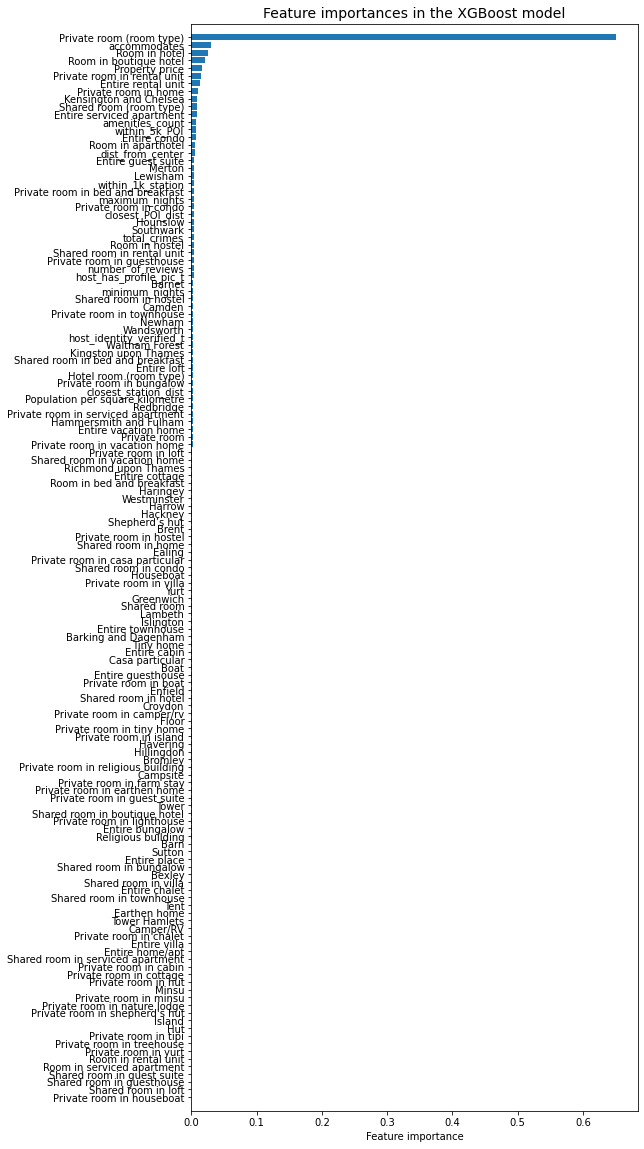

In [11]:
# Fitting the model
xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_val)

# Printing the results
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_val, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_val, val_preds_xgb_reg),4))

# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()